# Explicabilidade de Modelos de Aprendizado de Máquina

SHAP (SHapley Additive ExPlanations) é uma abordagem de Teoria dos Jogos para explicar o resultado de  modelos de aprendizagem de máquinas. Ele conecta a alocação ótima de créditos com explicações locais usando os valores clássicos de Shapley da teoria dos jogos.

Na aula de hoje, forneceremos uma breve introdução à esse conceito, sem nos atentar a tantos detalhes teóricos.





## Carregando Bibliotecas e Dados

Antes de usar **Shapley Values** para explicar modelos complicados, é útil entender como eles funcionam para modelos simples. Usaremos aqui o banco de dados do Titanic, pois já conhecemos, e treinaremos alguns modelos nele. O problema do Titanic é de classificação, mas vamos usar modelos de regressão em alguns casos, mesmo sabendo que não são tão apropriados, apenas para manter a explicação mais concisa.

In [1]:
# Explicabilidade
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

In [2]:
#!pip install shap
import shap

In [12]:
data = sns.load_dataset("titanic")

Antes de mais nada, vamos dar uma olhadinha nos dados.

In [13]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


## Pré-Processando os Dados

Vamos converter todos os dados que usaremos para números reais e lidar com *missing values*. Isso tornará os dados apropriados para qualquer modelo.



Como não usaremos todas as colunas, focaremos apenas nas que jugarmos mais importantes: **sex**, **pclass**, **age**, **sibsp**, **parch**, **fare** e **embarked**. As modificações que faremos já foram trabalhadas em notebooks anteriores e serão colocadas em apenas um notebook.

In [15]:
# Corrigindo missing values
medianAge = data.age.median()
data['age'] = data.age.fillna(medianAge)

medianFare = data.fare.median()
data['fare'] = data.fare.fillna(medianFare)

data["embarked"] = data.embarked.fillna("S")

data["sex"] = (data.sex == "female").astype(int)


## Convertendo para one-hot encoding

# Embarked
from sklearn import preprocessing
encoder = preprocessing.LabelBinarizer()
encoder.fit(data.embarked.values)

df_train_Embarked_encoded = pd.DataFrame(encoder.transform(data.embarked),
                                         columns = encoder.classes_)
data = pd.concat([data, df_train_Embarked_encoded], axis="columns")

# PClass
data["pclass"] = data.pclass.map(lambda x : "classe_"+str(x))
encoder = preprocessing.LabelBinarizer()
encoder.fit(data.pclass.values)

df_train_Pclass_encoded = pd.DataFrame(encoder.transform(data.pclass),
                                       columns = encoder.classes_)
data = pd.concat([data, df_train_Pclass_encoded], axis="columns")



Agora precisamos olhar os dados novamente.

In [16]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,...,deck,embark_town,alive,alone,C,Q,S,classe_1,classe_2,classe_3
0,0,classe_3,0,22.0,1,0,7.2500,S,Third,man,...,NaN,Southampton,no,False,0,0,1,0,0,1
1,1,classe_1,1,38.0,1,0,71.2833,C,First,woman,...,C,Cherbourg,yes,False,1,0,0,1,0,0
2,1,classe_3,1,26.0,0,0,7.9250,S,Third,woman,...,NaN,Southampton,yes,True,0,0,1,0,0,1
3,1,classe_1,1,35.0,1,0,53.1000,S,First,woman,...,C,Southampton,yes,False,0,0,1,1,0,0
4,0,classe_3,0,35.0,0,0,8.0500,S,Third,man,...,NaN,Southampton,no,True,0,0,1,0,0,1


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    object  
 2   sex          891 non-null    int64   
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
 15  C            891 non-null    int64   
 16  Q            891 non-null    int64   
 17  S            891 non-null    int64   
 18  classe_1     891 non-null    i

Agora, podemos separar os dados que queremos.

In [18]:
X = data.loc[: , ["sex", "age", "sibsp", 'parch','fare', 'C', 'Q', 'S', 'classe_1', 'classe_2', 'classe_3']]
y = data.survived


## Regressão Linear

Para treinar um modelo de regressão Linear é simples:

In [19]:
model_linear = sklearn.linear_model.LinearRegression()
model_linear.fit(X, y)

LinearRegression()

A maneira mais comum de entender um modelo linear é examinar os coeficientes aprendidos para cada característica. Estes coeficientes nos dizem o quanto a saída do modelo muda quando alteramos cada uma das características de entrada:

In [20]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model_linear.coef_[i].round(5))


Model coefficients:

sex = 0.50401
age = -0.00573
sibsp = -0.0412
parch = -0.01605
fare = 0.00035
C = 0.02395
Q = 0.01917
S = -0.04312
classe_1 = 0.15988
classe_2 = 0.01584
classe_3 = -0.17572


Embora os coeficientes sejam ótimos para nos dizer o que acontecerá quando mudarmos o valor de uma característica de entrada, por si só não são uma ótima maneira de medir a importância geral de uma característica. Isto porque o valor de cada coeficiente depende da escala das características de entrada. A coluna **age**, por exemplo, possui uma escala muito maior que as outras características, o que foi levado em conta pelo modelo.

## Gráfico de Dependência Parcial de um Modelo de Regressão Linear

O **gráfico de dependência parcial** (PDP, do inglês *Partial Dependence Plot*) é uma técnica usada para visualizar a relação entre uma ou mais features (variáveis independentes) e o resultado previsto (variável dependente) de um modelo de machine learning, mantendo as outras features constantes. No contexto de um **modelo de regressão linear**, o gráfico de dependência parcial ajuda a entender como cada feature influencia a previsão do modelo de forma isolada, ignorando as interações com outras variáveis.

### Objetivo do Gráfico de Dependência Parcial

O objetivo do **gráfico de dependência parcial** é responder à seguinte pergunta:

> Como a previsão do modelo muda à medida que uma feature específica varia, mantendo todas as outras features constantes?

Isso permite que você observe o efeito "parcial" de uma feature em particular, independentemente de como as outras variáveis afetam o modelo.

### No Contexto da Regressão Linear

Em um modelo de **regressão linear**:

$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n
$$

- $ \hat{y} $ é a previsão do modelo.
- $ \beta_0 $ é o intercepto.
- $ \beta_1, \beta_2, \dots, \beta_n $ são os coeficientes das variáveis $ x_1, x_2, \dots, x_n $.

Um **gráfico de dependência parcial** ajuda a ver o efeito de uma feature $ x_i $ (ou de um conjunto de features) na previsão $ \hat{y} $, enquanto mantemos as outras features constantes.

### Como Funciona o Gráfico de Dependência Parcial

Para gerar um gráfico de dependência parcial para uma feature $ x_i $:

1. **Fixar todas as outras variáveis**: Para calcular o efeito de uma feature específica, todas as outras variáveis são mantidas constantes.
2. **Variação da feature de interesse**: A feature $ x_i $ é variada ao longo de seu intervalo de valores.
3. **Previsão média**: Para cada valor da feature $ x_i $, as previsões do modelo são feitas, mantendo as outras features no mesmo valor (geralmente na média ou no valor observado). As previsões são então **médias** para cada valor da feature $ x_i $, resultando no gráfico de dependência parcial.

### Exemplo de Gráfico de Dependência Parcial na Regressão Linear

Vamos considerar um modelo de regressão linear simples com duas features $ x_1 $ (idade) e $ x_2 $ (experiência). Suponha que a equação do modelo seja:

$$
\hat{y} = 10 + 2x_1 + 3x_2
$$

Aqui:
- A previsão $ \hat{y} $ aumenta **2 unidades** para cada unidade adicional em $ x_1 $ (idade).
- A previsão $ \hat{y} $ aumenta **3 unidades** para cada unidade adicional em $ x_2 $ (experiência).

#### Dependência Parcial de $ x_1 $ (Idade):
- Para observar como a **idade** ($ x_1 $) afeta a previsão, mantemos a **experiência** ($ x_2 $) constante, por exemplo, na média de $ x_2 $.
- Variamos $ x_1 $ ao longo de um intervalo de valores, digamos de 20 a 60 anos.
- Para cada valor de $ x_1 $, fazemos a previsão $ \hat{y} $ e plotamos o gráfico de $ x_1 $ versus $ \hat{y} $.

No caso de uma **regressão linear**, o gráfico de dependência parcial será uma linha reta, pois a relação entre a feature e a variável resposta é linear. Isso significa que, à medida que $ x_1 $ (idade) aumenta, a previsão $ \hat{y} $ aumenta de forma proporcional, com uma inclinação determinada pelo coeficiente $ \beta_1 $.

#### Dependência Parcial de $ x_2 $ (Experiência):
- Da mesma forma, podemos observar o efeito de $ x_2 $ (experiência) no modelo mantendo $ x_1 $ (idade) constante.
- Isso resultará em outro gráfico de linha reta, onde o valor de $ x_2 $ é variado e a previsão é calculada e plotada.

### Interpretação

- **Inclinação**: Em um modelo de regressão linear, o gráfico de dependência parcial terá uma inclinação constante, que é o coeficiente da feature sendo analisada. Uma inclinação positiva significa que a feature tem um impacto positivo na previsão, e uma inclinação negativa indica um impacto negativo.
- **Intercepto**: O intercepto do gráfico representa o valor previsto para a variável $ y $ quando a feature em questão é zero (ou seja, o valor base quando a feature não está contribuindo).

### Limitações

- **Interações**: O gráfico de dependência parcial para regressão linear ignora qualquer **interação** entre as variáveis. Se houver interações significativas entre as variáveis no modelo, o gráfico de dependência parcial não mostrará essas dependências cruzadas.
- **Simplicidade**: Em uma regressão linear, o gráfico de dependência parcial é mais simples de interpretar porque a relação entre as variáveis é linear. Em modelos mais complexos (como árvores de decisão ou redes neurais), os gráficos de dependência parcial podem ser curvilíneos e mais difíceis de interpretar.


### Voltando ao exemplo
Antes de mais nada, não iremos utilizar o conjunto completo de instâncias, mas um conjunto de dados reduzido que chamaremos de **X100**, dado que possui 100 instâncias escolhidas ao acaso.





In [21]:
X100 = shap.utils.sample(X, 100)

Vamos construir um gráfico clássico de dependência parcial e mostrar a distribuição dos valores das características como um histograma no eixo x.

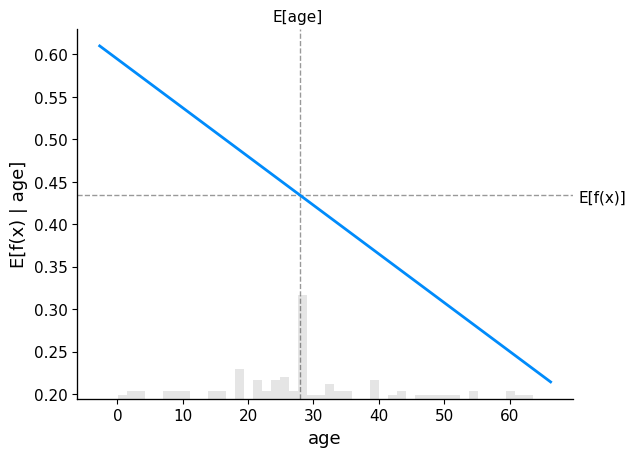

In [22]:
## Usando Age
shap.partial_dependence_plot(
    "age", model_linear.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Este gráfico de **dependência parcial** (PDP) foi gerado para a variável **age** (idade) mostra como a idade afeta as previsões do modelo, mantendo as outras variáveis constantes. Aqui estão os pontos principais para interpretar o gráfico:

### Eixo $ x $ (Idade)
O eixo $ x $ representa a **idade** dos passageiros. No gráfico, a idade varia de 0 a cerca de 60 anos.

### Eixo $ y $ (E[f(x) | age])
O eixo $ y $ mostra o **valor esperado da função preditiva** do modelo, dado o valor de idade. Isso significa que o eixo $ y $ nos diz como o modelo prevê as chances de um passageiro sobreviver à medida que sua idade muda, enquanto as outras variáveis (como sexo, classe, etc.) são mantidas constantes.

### Interpretação da Linha Azul (Efeito da Idade na Previsão)

- **Linha Descendente**: A linha azul indica que, à medida que a idade aumenta, a previsão do modelo diminui. No contexto do Titanic, isso pode ser interpretado como uma **redução na probabilidade de sobrevivência à medida que a idade aumenta**. Ou seja, passageiros mais velhos tendem a ter uma menor chance de sobrevivência de acordo com o modelo.
  
- **Inclinação**: A inclinação negativa da linha indica uma relação inversa entre a idade e a previsão. Uma linha descendente tão clara sugere que a idade é uma variável importante para o modelo de predição.

### Ponto Médio: $ E[\text{age}] $
A linha tracejada vertical no centro do gráfico marca a **idade média** dos passageiros (aproximadamente 30 anos), enquanto a linha tracejada horizontal indica o valor esperado das previsões, ou seja, $ E[f(x)] $, o valor médio predito pelo modelo.

- No ponto de interseção, podemos ver que a previsão esperada para a idade média (30 anos) está levemente abaixo de 0.40, o que pode indicar uma probabilidade de sobrevivência moderada.

### Distribuição de Idade (Histograma)
Na parte inferior do gráfico, há um **histograma** em cinza, que representa a distribuição da variável **idade** no conjunto de dados. Esse histograma nos dá uma ideia de como as idades estão distribuídas entre os passageiros. A barra mais alta ao redor dos 30 anos sugere que muitos passageiros tinham idades próximas a esse valor.

### Resumo da Interpretação
- Passageiros **mais jovens** têm uma **maior probabilidade de sobrevivência** no modelo, enquanto passageiros **mais velhos** têm uma probabilidade menor.
- A **idade média** dos passageiros está em torno de 30 anos, e a previsão para essa faixa etária é em torno de 0.40, ou seja, uma chance moderada de sobrevivência.
- O modelo parece considerar a **idade** uma variável importante, com uma influência significativa e inversa sobre a probabilidade de sobrevivência.

Em resumo, o gráfico sugere que, de acordo com o modelo, ser mais jovem aumenta as chances de sobrevivência, e essa relação é linear e negativa.


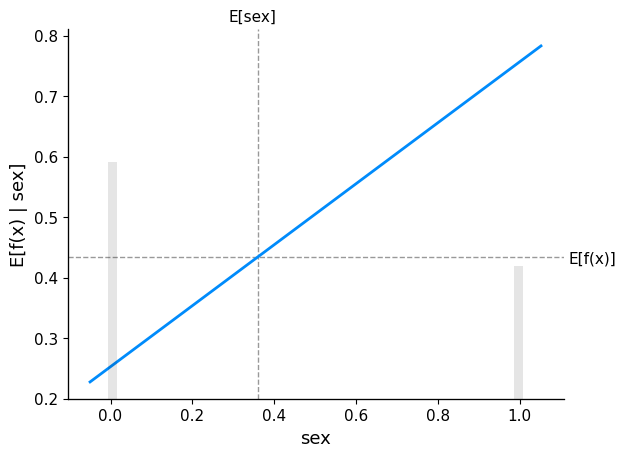

In [23]:
## Usando Sex
shap.partial_dependence_plot(
    "sex", model_linear.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Este gráfico de **dependência parcial** (PDP) gerado para a variável **sex** (sexo) do conjunto de dados do Titanic mostra como o sexo afeta as previsões do modelo, mantendo as outras variáveis constantes.

### Eixo $ x $ (Sexo)
O eixo $ x $ representa a variável **sex** (sexo) codificada como uma variável binária, onde:
- **0**  representa **homens**,
- **1**  representa **mulheres**.

### Eixo $ y $ (E[f(x) | sex])
O eixo $ y $ mostra o **valor esperado da função preditiva** do modelo dado o valor de sexo. Isso significa que o eixo $ y $ nos diz como o modelo prevê as chances de um passageiro sobreviver à medida que a variável sexo muda, mantendo as outras variáveis constantes.

### Interpretação da Linha Azul (Efeito do Sexo na Previsão)

- **Linha Ascendente**: A linha azul indica que, à medida que passamos de **0 (homens)** para **1 (mulheres)**, a previsão do modelo aumenta. No contexto do Titanic, isso sugere que as mulheres têm uma **maior probabilidade de sobrevivência** em comparação com os homens, de acordo com o modelo.
  
- **Inclinação**: A inclinação positiva da linha indica uma relação direta entre o sexo e a previsão do modelo. Mulheres (sexo = 1) têm uma probabilidade maior de sobrevivência, enquanto homens (sexo = 0) têm uma probabilidade menor.

### Ponto Médio: $ E[\text{sex}] $
A linha tracejada vertical no gráfico marca a **média** da variável sexo (provavelmente ao redor de 0.5, dado que o sexo é uma variável binária). A linha tracejada horizontal indica o valor esperado da previsão $ E[f(x)] $, ou seja, o valor médio predito pelo modelo.

- A previsão para homens (sexo = 0) parece estar abaixo de 0.30, enquanto para mulheres (sexo = 1), a previsão se aproxima de 0.60, sugerindo que o modelo atribui uma probabilidade significativamente maior de sobrevivência às mulheres.

### Distribuição de Sexo (Histograma)
Na parte inferior do gráfico, há um **histograma** em cinza que mostra a distribuição da variável sexo no conjunto de dados. A barra à esquerda indica a proporção de homens, e a barra à direita indica a proporção de mulheres. Isso mostra que há um número significativo de ambos os sexos no conjunto de dados, com talvez uma leve predominância de homens (supondo que o valor 0 seja homens).

### Resumo da Interpretação
- **Homens (sexo = 0)** têm uma **menor probabilidade de sobrevivência** de acordo com o modelo, com uma previsão esperada em torno de 0.25.
- **Mulheres (sexo = 1)** têm uma **maior probabilidade de sobrevivência**, com uma previsão esperada em torno de 0.55 a 0.60.
- O modelo parece atribuir uma **forte influência positiva** ao fato de ser mulher na probabilidade de sobrevivência.

Em resumo, o gráfico mostra que o **sexo** tem uma influência significativa sobre a previsão do modelo, com mulheres tendo uma probabilidade muito maior de sobrevivência em comparação com homens no cenário do Titanic.


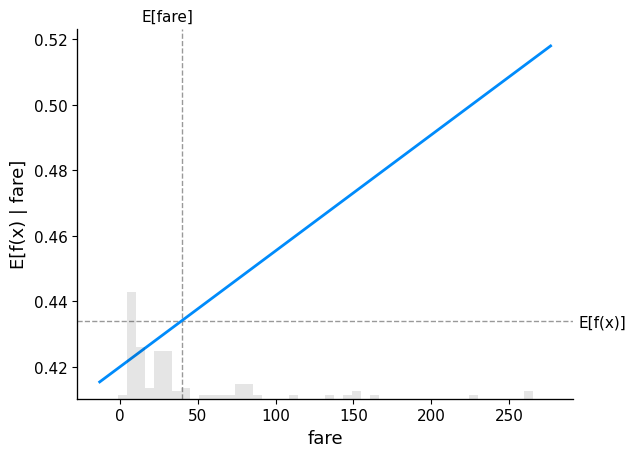

In [24]:
## Usando Fare
shap.partial_dependence_plot(
    "fare", model_linear.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Este gráfico de **dependência parcial** (PDP) foi gerado para a variável **fare** (tarifa, ou preço do ticket) do conjunto de dados do Titanic. Ele mostra como o valor da tarifa afeta as previsões do modelo, mantendo as outras variáveis constantes.

### Eixo $ x $ (Fare)
O eixo $ x $ representa a variável **fare** (tarifa) paga pelos passageiros. Os valores de tarifa variam de 0 até cerca de 200.

### Eixo $ y $ (E[f(x) | fare])
O eixo $ y $ mostra o **valor esperado da função preditiva** do modelo, dado o valor da tarifa. Isso significa que o eixo $ y $ nos diz como o modelo prevê as chances de um passageiro sobreviver à medida que o valor da tarifa muda, enquanto as outras variáveis são mantidas constantes.

### Interpretação da Linha Azul (Efeito da Tarifa na Previsão)

- **Linha Ascendente**: A linha azul indica que, à medida que o valor da tarifa aumenta, a previsão do modelo também aumenta. Isso sugere que passageiros que pagaram tarifas mais altas tinham uma **maior probabilidade de sobrevivência** no Titanic, de acordo com o modelo.

- **Inclinação**: A inclinação positiva da linha reflete que, conforme a tarifa aumenta, a previsão do modelo aumenta de forma contínua. Passageiros que pagaram tarifas mais altas estavam, em geral, em classes superiores, o que provavelmente aumentou suas chances de sobreviver, já que essas classes foram priorizadas no resgate.

### Ponto Médio: $ E[\text{fare}] $
A linha tracejada vertical no gráfico marca a **média** do valor das tarifas pagas, enquanto a linha tracejada horizontal indica o valor esperado das previsões $ E[f(x)] $, ou seja, o valor médio predito pelo modelo.

- Passageiros que pagaram valores de tarifa mais próximos da média (em torno de 30-40) têm uma previsão esperada em torno de 0.40. Passageiros que pagaram tarifas mais altas têm uma previsão maior.

### Distribuição de Tarifa (Histograma)
Na parte inferior do gráfico, há um **histograma** em cinza que mostra a distribuição dos valores de tarifa no conjunto de dados. O histograma revela que a maioria dos passageiros pagou tarifas relativamente baixas (muitas tarifas abaixo de 50). Poucos passageiros pagaram tarifas acima de 100.

### Resumo da Interpretação

- Passageiros que pagaram tarifas **mais baixas** (menos de 50) têm uma **menor probabilidade de sobrevivência** de acordo com o modelo, com uma previsão em torno de 0.38 a 0.42.
- Passageiros que pagaram tarifas **mais altas** (acima de 50) têm uma **maior probabilidade de sobrevivência**, com a previsão aumentando à medida que o valor da tarifa aumenta.
- O modelo sugere que o **valor da tarifa** é um fator importante na previsão da probabilidade de sobrevivência, com uma relação positiva clara entre a tarifa paga e a sobrevivência, possivelmente devido à correlação entre tarifa e classe social no Titanic.

Em resumo, o gráfico mostra que passageiros que pagaram tarifas mais altas (provavelmente em classes superiores) tinham maiores chances de sobrevivência, de acordo com o modelo de predição.


Em cada um dos exemplos acima, a linha horizontal cinza representa o valor esperado do modelo quando aplicado ao conjunto de 100 instâncias de dados. No caso do nosso banco, quando o modelo é aplicado a todas as instâncias, o valor médio retornado está muito próximo de 40\%.

A linha cinza vertical representa o valor médio da característica (**age**, **sex** e **fare**) nas 100 instâncias que escolhemos. A linha azul do gráfico  é o valor esperado da saída do modelo quando fixamos a característica **age** em um número dado pelo eixo X.

Note que a linha azul do gráfico de dependência parcial sempre passa pela interseção das duas linhas cinzas. Podemos considerar este ponto de interseção como o *centro* do gráfico de dependência parcial em relação à distribuição de dados de 100 instâncias.

Note nos gráficos anteriores que o eixo Y de algumas características varia mais do que o de outras quando variamos os valores.

# Shapley Values

## Explicação dos Valores de Shapley para Três Jogadores: Maria, Pedro e João

### Cenário:
Temos três jogadores: **Maria**, **Pedro** e **João** que cooperam entre si para realizar uma tarefa. O objetivo é calcular quanto cada jogador contribui para o sucesso do grupo utilizando **valores de Shapley**.

Os valores de Shapley fornecem uma maneira justa de distribuir a recompensa total entre os jogadores de um grupo, levando em consideração todas as possíveis combinações de jogadores. A ideia é calcular a contribuição marginal de cada jogador ao ser adicionado a um subconjunto de outros jogadores.

### Passo 1: Função de Valor
Na teoria dos jogos, uma **função de valor** $ v(S) $ atribui um valor a cada subconjunto de jogadores $ S $. Este valor representa o que o subconjunto de jogadores $ S $ pode realizar por conta própria. Aqui, definimos o valor $ v(S) $ para cada subconjunto de jogadores.

Exemplo:
- Se o conjunto $ S $ contiver apenas **Maria**, $ v(\{\text{Maria}\}) $ representa o que Maria pode realizar sozinha.
- Se o conjunto $ S $ contiver **Maria e Pedro**, $ v(\{\text{Maria}, \text{Pedro}\}) $ representa o que Maria e Pedro podem realizar juntos.

### Passo 2: Definir os Conjuntos de Jogadores
Para três jogadores, temos os seguintes **subconjuntos possíveis**:
1. Subconjuntos sem nenhum jogador:
   - $ S = \{\} $ (conjunto vazio)
   
2. Subconjuntos com **um jogador**:
   - $ S = \{\text{Maria}\} $
   - $ S = \{\text{Pedro}\} $
   - $ S = \{\text{Joao}\} $
   
3. Subconjuntos com **dois jogadores**:
   - $ S = \{\text{Maria}, \text{Pedro}\} $
   - $ S = \{\text{Maria}, \text{Joao}\} $
   - $ S = \{\text{Pedro}, \text{Joao}\} $
   
4. O subconjunto com **todos os três jogadores**:
   - $ S = \{\text{Maria}, \text{Pedro}, \text{Joao}\} $

### Passo 3: Contribuição Marginal
A **contribuição marginal** de um jogador $ i $ é o quanto o valor total muda ao **adicionar** esse jogador a um subconjunto $ S $.

$$

\text{Contribuição marginal de } i \text{ para } S = v(S \cup \{i\}) - v(S)
$$

Exemplo: Se adicionarmos Maria a um subconjunto $ S $, a contribuição marginal de Maria será o quanto ela aumenta o valor do conjunto $ S $.

### Passo 4: Cálculo dos Valores de Shapley
Os **valores de Shapley** calculam a contribuição de cada jogador com base em **todos os subconjuntos possíveis** dos outros jogadores. A fórmula geral para o valor de Shapley de um jogador $ i $ é:

$$
\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! \cdot (|N| - |S| - 1)!}{|N|!} \cdot [v(S \cup \{i\}) - v(S)]
$$

Aqui:
- $ N $ é o conjunto de todos os jogadores.
- $ S $ é um subconjunto de $ N $ sem o jogador $ i $.
- $ |S| $ é o tamanho do subconjunto $ S $.
- $ \phi_i $ é o valor de Shapley do jogador $ i $.
- $|S|! $ Representa o número de maneiras de ordenar os jogadores no subconjunto $ S $, o que reflete a probabilidade de $S$ já ter se formado antes de $i$ ser adicionado.
- $ (|N| - |S| - 1)!$ representa o número de maneiras de ordenar os jogadores que ainda não estão no subconjunto $S$, após $i$ ter sido adicionado. Isso reflete a probabilidade de que, depois de adicionar $i$, o restante dos jogadores se junte em qualquer ordem.

### Exemplo Numérico:
Vamos supor que temos a seguinte função de valor $ v(S) $ para diferentes subconjuntos:

- $ v(\{\}) = 0 $  (Nenhum jogador sozinho faz nada).
- $ v(\{\text{Maria}\}) = 10 $  (Maria sozinha faz 10).
- $ v(\{\text{Pedro}\}) = 15 $  (Pedro sozinho faz 15).
- $ v(\{\text{Joao}\}) = 5 $  (João sozinho faz 5).
- $ v(\{\text{Maria}, \text{Pedro}\}) = 30 $  (Maria e Pedro juntos fazem 30).
- $ v(\{\text{Maria}, \text{Joao}\}) = 18 $  (Maria e João juntos fazem 18).
- $ v(\{\text{Pedro}, \text{Joao}\}) = 20 $  (Pedro e João juntos fazem 20).
- $ v(\{\text{Maria}, \text{Pedro}, \text{Joao}\}) = 40 $  (Todos juntos fazem 40).

#### Cálculo do Valor de Shapley para Maria:

A contribuição marginal de Maria em cada subconjunto é:
- $ S = \{\} $: $ v(\{\text{Maria}\}) - v(\{\}) = 10 - 0 = 10 $
- $ S = \{\text{Pedro}\} $: $ v(\{\text{Maria}, \text{Pedro}\}) - v(\{\text{Pedro}\}) = 30 - 15 = 15 $
- $ S = \{\text{Joao}\} $: $ v(\{\text{Maria}, \text{Joao}\}) - v(\{\text{Joao}\}) = 18 - 5 = 13 $
- $ S = \{\text{Pedro}, \text{Joao}\} $: $ v(\{\text{Maria}, \text{Pedro}, \text{Joao}\}) - v(\{\text{Pedro}, \text{Joao}\}) = 40 - 20 = 20 $

Agora, calculamos a ponderação para cada subconjunto:

- Para $ S = \{\} $, $ \frac{|S|! \cdot (|N| - |S| - 1)!}{|N|!} = \frac{0! \cdot 2!}{3!} = \frac{1 \cdot 2}{6} = \frac{1}{3} $
- Para $ S = \{\text{Pedro}\} $, $ \frac{1! \cdot 1!}{3!} = \frac{1 \cdot 1}{6} = \frac{1}{6} $
- Para $ S = \{\text{Joao}\} $, $ \frac{1! \cdot 1!}{3!} = \frac{1 \cdot 1}{6} = \frac{1}{6} $
- Para $ S = \{\text{Pedro}, \text{Joao}\} $, $ \frac{2! \cdot 0!}{3!} = \frac{2 \cdot 1}{6} = \frac{1}{3} $

Somando as contribuições ponderadas de Maria:

$$
\phi_{\text{Maria}} = \frac{1}{3} \cdot 10 + \frac{1}{6} \cdot 15 + \frac{1}{6} \cdot 13 + \frac{1}{3} \cdot 20 = 3.33 + 2.5 + 2.17 + 6.67 = 14.67
$$

#### 2. Valor de Shapley para Pedro

A contribuição marginal de **Pedro** para cada subconjunto é:

- Para $ S = \{\} $: $ v(\{\text{Pedro}\}) - v(\{\}) = 15 - 0 = 15 $
- Para $ S = \{\text{Maria}\} $: $ v(\{\text{Maria}, \text{Pedro}\}) - v(\{\text{Maria}\}) = 30 - 10 = 20 $
- Para $ S = \{\text{Joao}\} $: $ v(\{\text{Pedro}, \text{Joao}\}) - v(\{\text{Joao}\}) = 20 - 5 = 15 $
- Para $ S = \{\text{Maria}, \text{Joao}\} $: $ v(\{\text{Maria}, \text{Pedro}, \text{Joao}\}) - v(\{\text{Maria}, \text{Joao}\}) = 40 - 18 = 22 $

Somando as contribuições ponderadas de Pedro:

$$
\phi_{\text{Pedro}} = \frac{1}{3} \cdot 15 + \frac{1}{6} \cdot 20 + \frac{1}{6} \cdot 15 + \frac{1}{3} \cdot 22 = 5 + 3.33 + 2.5 + 7.33 = 18.17
$$

#### 3. Valor de Shapley para João

A contribuição marginal de **João** para cada subconjunto é:

- Para $ S = \{\} $: $ v(\{\text{Joao}\}) - v(\{\}) = 5 - 0 = 5 $
- Para $ S = \{\text{Maria}\} $: $ v(\{\text{Maria}, \text{Joao}\}) - v(\{\text{Maria}\}) = 18 - 10 = 8 $
- Para $ S = \{\text{Pedro}\} $: $ v(\{\text{Pedro}, \text{Joao}\}) - v(\{\text{Pedro}\}) = 20 - 15 = 5 $
- Para $ S = \{\text{Maria}, \text{Pedro}\} $: $ v(\{\text{Maria}, \text{Pedro}, \text{Joao}\}) - v(\{\text{Maria}, \text{Pedro}\}) = 40 - 30 = 10 $

Somando as contribuições ponderadas de João:

$$
\phi_{\text{Joao}} = \frac{1}{3} \cdot 5 + \frac{1}{6} \cdot 8 + \frac{1}{6} \cdot 5 + \frac{1}{3} \cdot 10 = 1.67 + 1.33 + 0.83 + 3.33 = 7.17
$$

### Aditividade

Os valores de Shapley são aditivos no sentido de que a soma das contribuições de todos os jogadores deve ser igual ao valor final obtido pelo grupo. Essa aditividade garante que cada jogador seja considerado de forma justa e que todas as contribuições sejam levadas em conta no resultado total.


$$
\phi_{\text{Maria}} + \phi_{\text{Pedro}} + \phi_{\text{Joao}} = 14.67 + 18.17 + 7.17 = 40
$$

A soma dos valores de Shapley é **40**, que é o valor total que o grupo completo gera, garantindo a **aditividade**.


Note que a propriedade de aditividade dos valores de Shapley é garantida somente quando somamos as contribuições de todos os jogadores. Quando analisamos subconjuntos menores (duplas, por exemplo), a soma dos valores de Shapley não necessariamente corresponde ao valor gerado apenas por esses subconjuntos, porque estamos levando em consideração as contribuições em todos os contextos possíveis.

### Shapley Values

A idéia central por trás das explicações baseadas no valor de Shapley dos modelos de aprendizagem de máquinas é usar os resultados da alocação justa da teoria de jogos cooperativos para alocar crédito para a saída de um modelo entre as carcterísticas de entrada

A fim de conectar a teoria do jogo com os modelos de aprendizagem da máquina, é necessário combinar as características de entrada de um modelo com os jogadores em um jogo, e também combinar a função do modelo com as regras do jogo. Nesse caso:

* Jogo: reprodução das saídas do modelo.

* Jogadores: características (*features*) do modelo.


Como na teoria dos jogos um jogador pode participar ou não de um jogo, precisamos de uma maneira de definir se uma característica vai *participar* ou *não participar* de um modelo.

É importante ressaltar que o que chamamos de "jogo" diz respeito a uma única observação. Um jogo quer dizer uma única observação. De fato, o valor de SHAP é relacionado à interpretabilidade local de um modelo preditivo.


A maneira mais comum de definir o que significa para uma característica *participar* de um modelo é dizer que essa característica *participou em um modelo* quando usamos realmente o valor dessa característica, e não *participou em um modelo* quando não usamos o valor dessa característica.


## Como uma Feature pode "não participar" em Modelos de Aprendizado de Máquina?

Em aprendizado de máquina, a entrada de um modelo é composta por todas as **features** de um exemplo de dados. No entanto, ao usar **valores de Shapley**, a ideia de uma feature "não participar" significa que imaginamos um cenário hipotético em que **essa feature é ausente ou substituída por um valor neutro** ao calcular a previsão.

### Como uma Feature pode "não participar"?

Embora a entrada real para o modelo seja sempre composta por todas as features, os valores de Shapley calculam a **contribuição marginal** de cada feature removendo-a ou substituindo-a em **subconjuntos hipotéticos** de features. Isso significa:

1. **Substituição por um valor neutro**: Se uma feature $x_i$ não participa de um subconjunto hipotético de features, seu valor é substituído por um valor neutro ou médio que representa a falta de conhecimento sobre essa feature. Esse valor neutro pode ser, por exemplo, a **média** ou **distribuição** da feature em questão, obtida do conjunto de dados de treino.

2. **Predição sem a feature**: Quando calculamos o valor de Shapley para uma feature, simulamos o que aconteceria se essa feature estivesse **indisponível** para o modelo. Isso é feito removendo a feature do subconjunto ou mantendo seu valor "desconhecido", e em seguida, observamos como isso muda a previsão do modelo.

### Exemplo de "não participação" no modelo

Imagine que temos um modelo de **regressão linear** com três features: **idade (age)**, **tarifa (fare)** e **sexo (sex)**, e queremos calcular os valores de Shapley. Se queremos entender o valor de Shapley da feature **idade**, o processo seria:

1. **Remover a idade (hipoteticamente)**: Simulamos previsões para subconjuntos de features que **não incluem a idade**. Em termos práticos, o modelo recebe uma média ou outro valor neutro para a feature **idade**, e então calculamos a previsão.

2. **Verificar a contribuição marginal**: Calculamos a diferença entre a previsão com e sem a feature **idade**. A diferença nos diz o quanto **idade** contribuiu para a previsão final do modelo.

- Suponha que você tenha as features **idade**, **sexo** e **tarifa**. Se você quiser calcular o valor de Shapley para a feature **sexo**, você verificaria o que o modelo prediz **sem conhecer o sexo do passageiro**. Isso poderia ser feito ao substituir o valor da feature **sexo** por sua média (digamos 0.5, se for uma variável binária) ou por um valor aleatório, e então comparando o impacto dessa substituição na previsão do modelo.
  
### Relação com Shapley:

Na fórmula dos **valores de Shapley**, essa "não participação" é representada pelos diferentes subconjuntos $ S \subseteq N \setminus \{i\} $ de features, onde $ S $ é o conjunto de features que estão presentes. O valor de Shapley para a feature $ i $ (por exemplo, **sexo**) é calculado ao observar a diferença nas previsões feitas **com e sem** essa feature $ i $, considerando todos os subconjuntos de features.


Em modelos de regressão linear, quando estamos explicando uma previsão $f(x)$ para uma característica $x$ em uma instância $i$, o valor SHAP para a característica  obtida com aquela instância é igual à diferença entre a saída esperada do modelo e o gráfico de dependência parcial no valor para $x_i$.

Para ter um exemplo, vamos obter os Shapley values com a biblioteca shap.

In [25]:
# Computando os valores de SHAP para o modelo linear.
explainer = shap.Explainer(model_linear.predict, X100)
shap_values = explainer(X)

PermutationExplainer explainer: 892it [01:44,  8.53it/s]                         


Agora vamos plotar esses shap values em cima do gráfico de dependência parcial padrão.

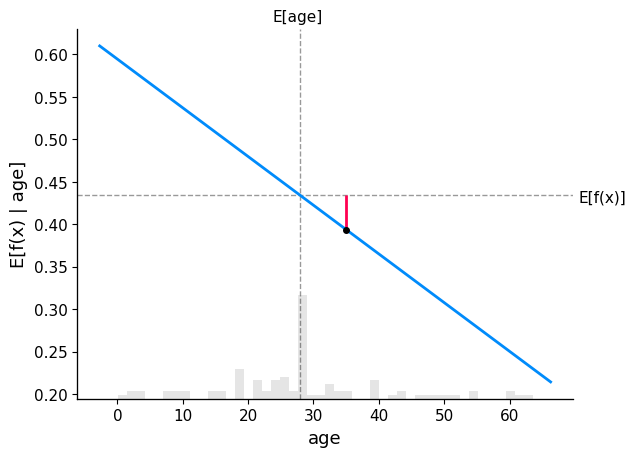

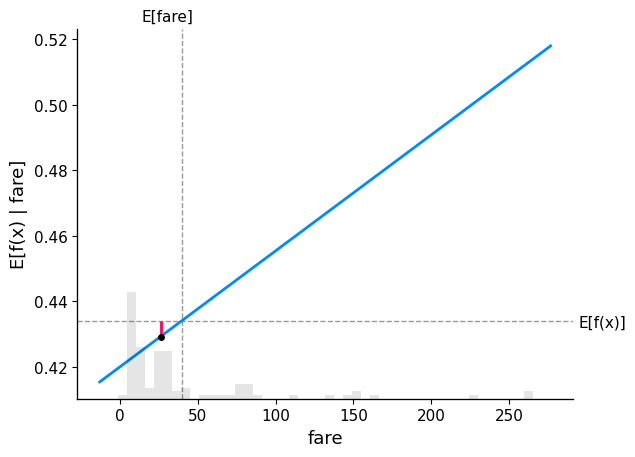

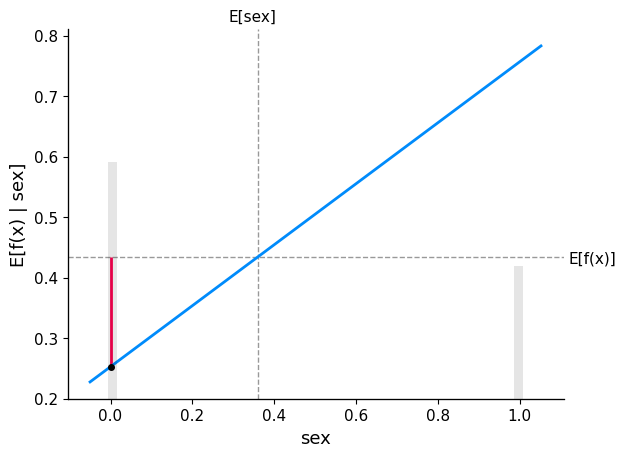

In [27]:
# Criando um gráfico parcial padrão e
# adicionando os SHAP Values para algumas instâncias
sample_ind = 20
shap.partial_dependence_plot(
    "age", model_linear.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

shap.partial_dependence_plot(
    "fare", model_linear.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

shap.partial_dependence_plot(
    "sex", model_linear.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

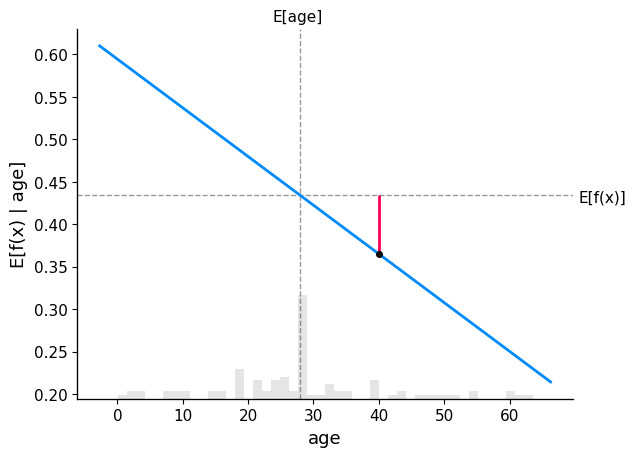

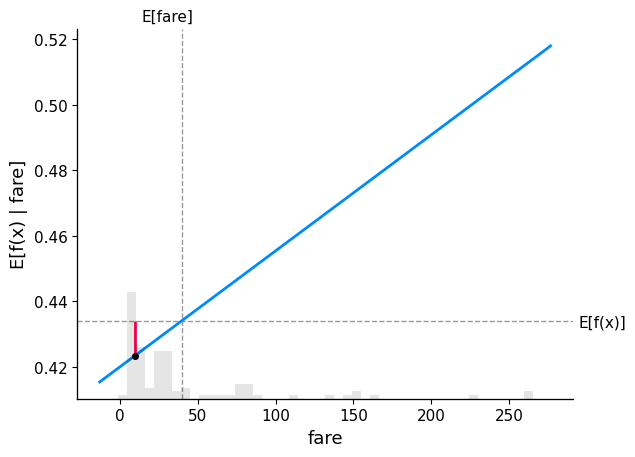

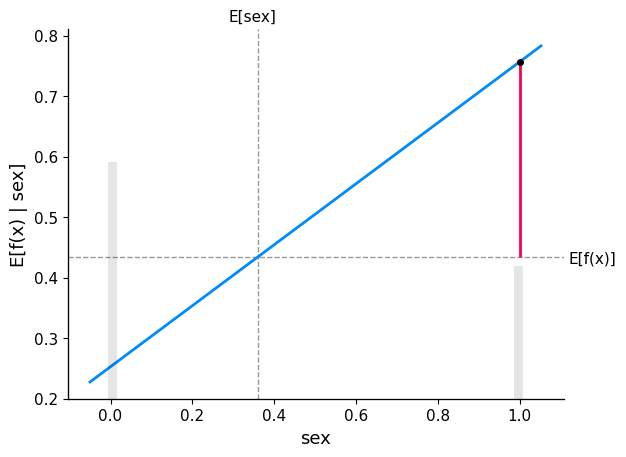

In [28]:
sample_ind = 40
shap.partial_dependence_plot(
    "age", model_linear.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

shap.partial_dependence_plot(
    "fare", model_linear.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

shap.partial_dependence_plot(
    "sex", model_linear.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

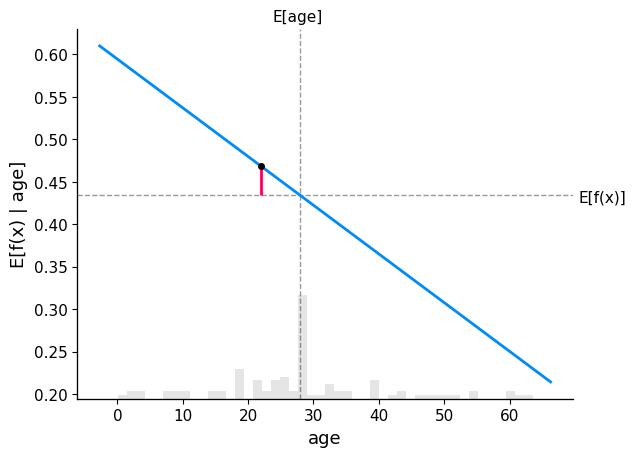

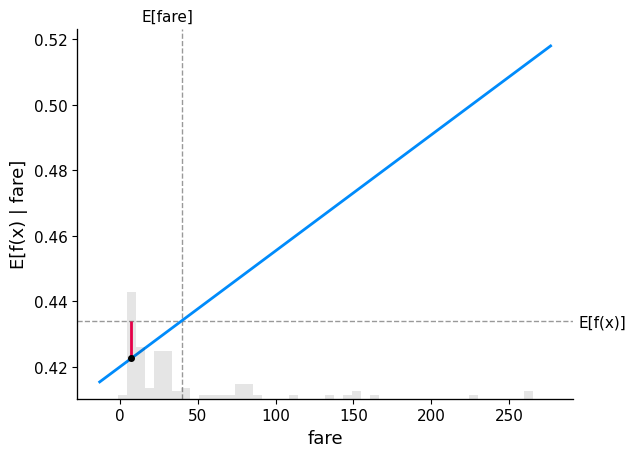

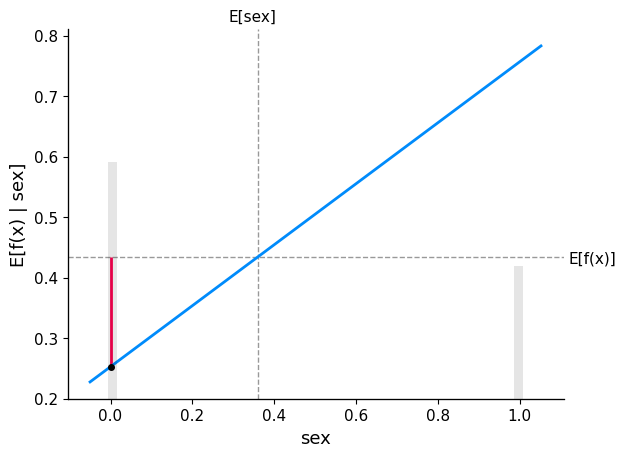

In [29]:
sample_ind = 60
shap.partial_dependence_plot(
    "age", model_linear.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

shap.partial_dependence_plot(
    "fare", model_linear.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

shap.partial_dependence_plot(
    "sex", model_linear.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

A estreita correspondência entre o gráfico clássico de dependência parcial e os valores SHAP indica que se colocarmos o valor SHAP para uma característica específica em um grafo, traçaremos exatamente uma versão centrada na média do gráfico de dependência parcial para essa característica:



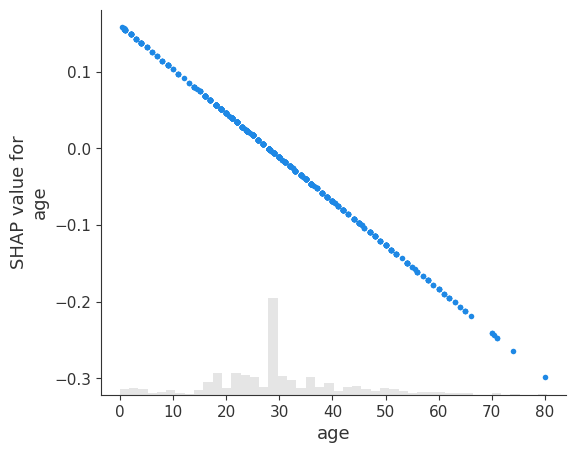

In [30]:
shap.plots.scatter(shap_values[:,"age"])


Uma das propriedades fundamentais dos Shapley values para todas as características de um modelo é que, fixada uma instância,  a soma dos Shapley values dessa instância sempre resulta na diferença entre o resultado do jogo quando todos os jogadores estão presentes e o resultado do jogo quando nenhum jogador está presente.

**Para modelos de aprendizagem de máquina, isto significa que, fixada uma instância, os valores SHAP de todas as características de entrada sempre se somarão à diferença entre a saída do modelo básico (esperado) e a saída do modelo atual para a previsão que está sendo explicada.**

Nesse caso, os valores de SHAP parciais da instância fornecem crédito para o quanto cada variável contribuiu para uma dada resposta.

A maneira mais fácil de ver esta contribuição é através de um gráfico *waterfall*.

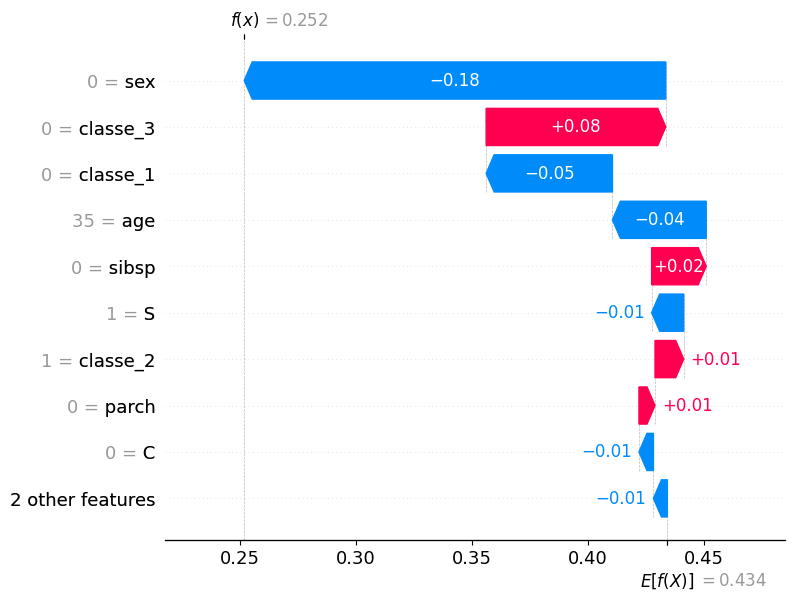

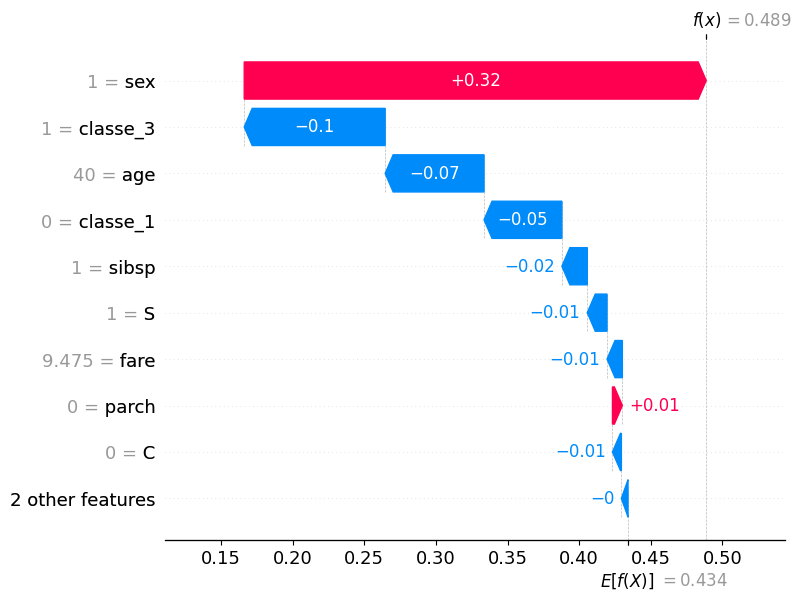

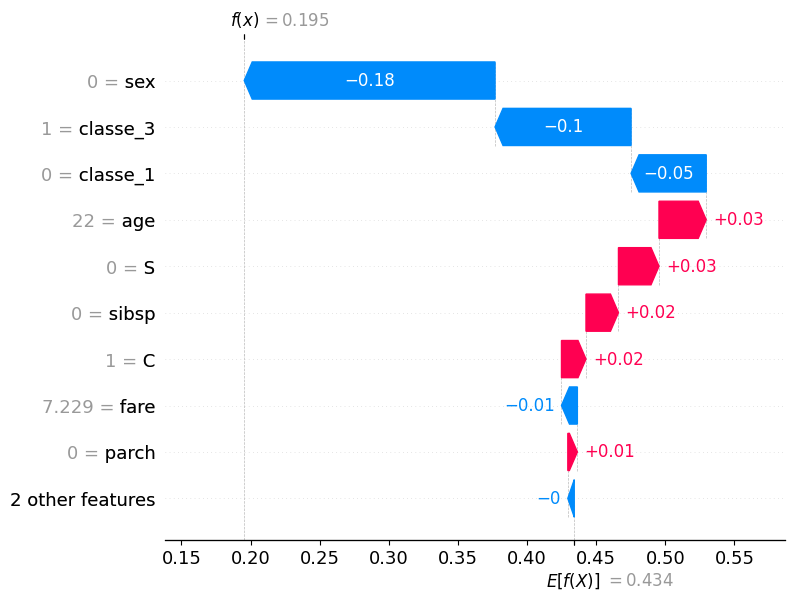

In [31]:
sample_ind = 20
shap.plots.waterfall(shap_values[sample_ind])

sample_ind = 40
shap.plots.waterfall(shap_values[sample_ind])

sample_ind = 60
shap.plots.waterfall(shap_values[sample_ind])

**Gráfico de Barras**

Por padrão, um gráfico de barras SHAP tomará o valor médio absoluto de cada característica sobre todas as instâncias (linhas) do conjunto de dados.



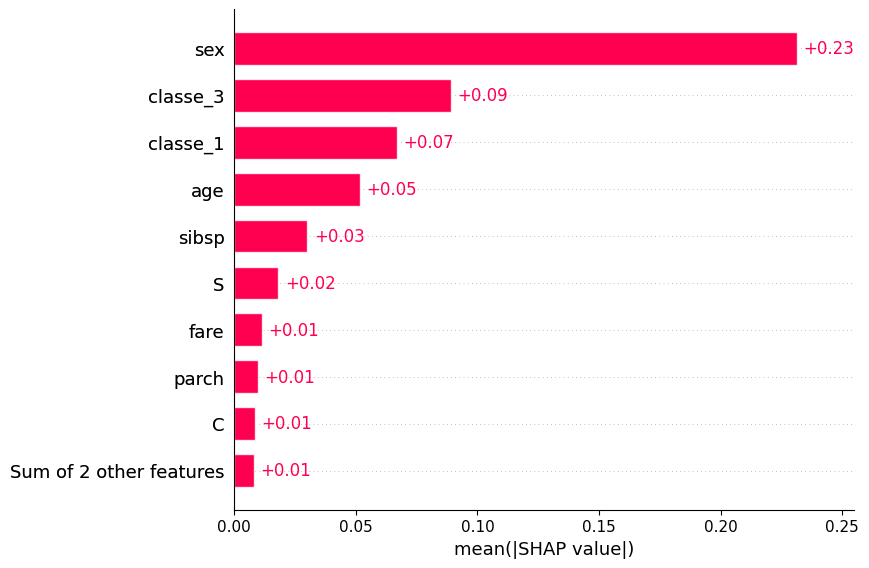

In [32]:
shap.plots.bar(shap_values)

Mas o valor médio absoluto não é a única maneira de criar uma medida global de importância de características, podemos usar quaisquer transformações. Aqui mostramos como a utilização sibsp pode ter impacto alto em algumas instâncias, apesar de infrequente

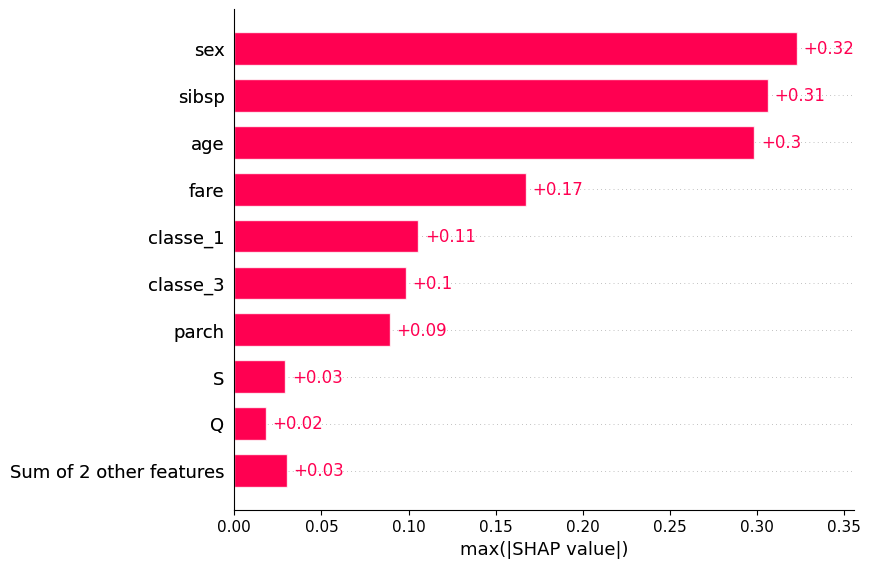

In [33]:
shap.plots.bar(shap_values.abs.max(0))

O beeswarm é um gráfico que pode revelar cenários não vistos nos anteriores:

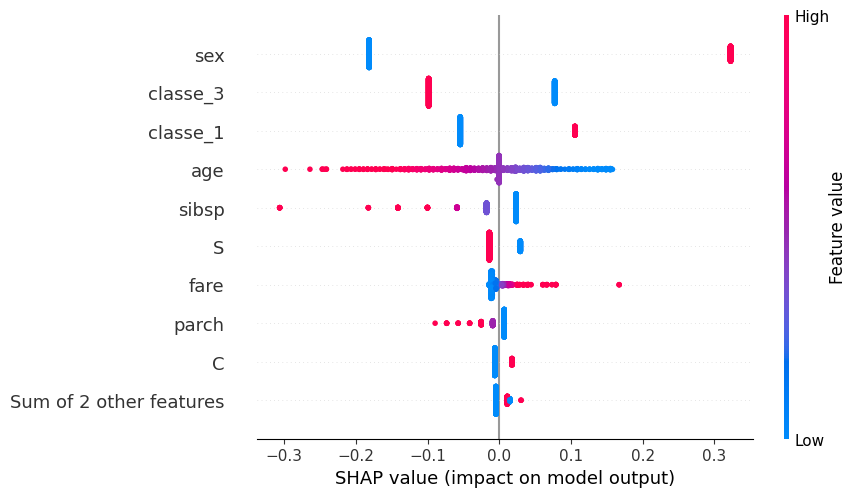

In [34]:
shap.plots.beeswarm(shap_values)

Usando o valor absoluto e  uma cor sólida, obtemos um compromisso entre a complexidade do histograma e do beeswarm.

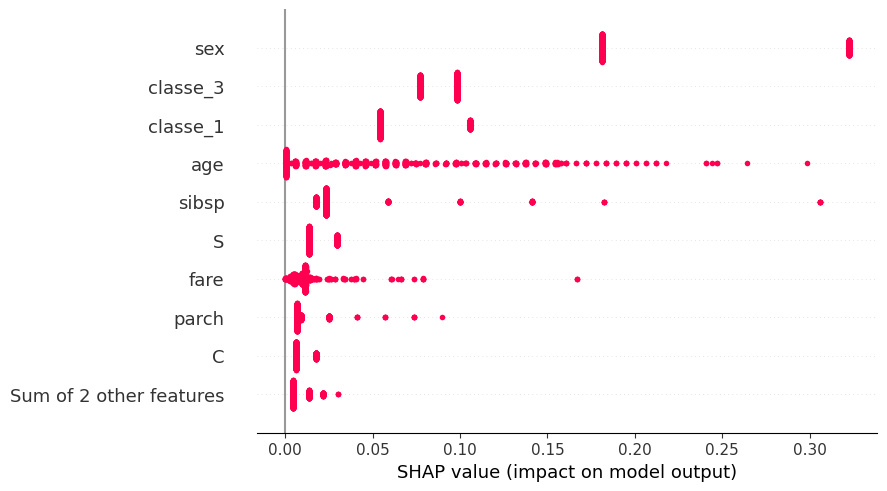

In [38]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")


Uma outra opção seria o *heatmap* se você quer complexidade.

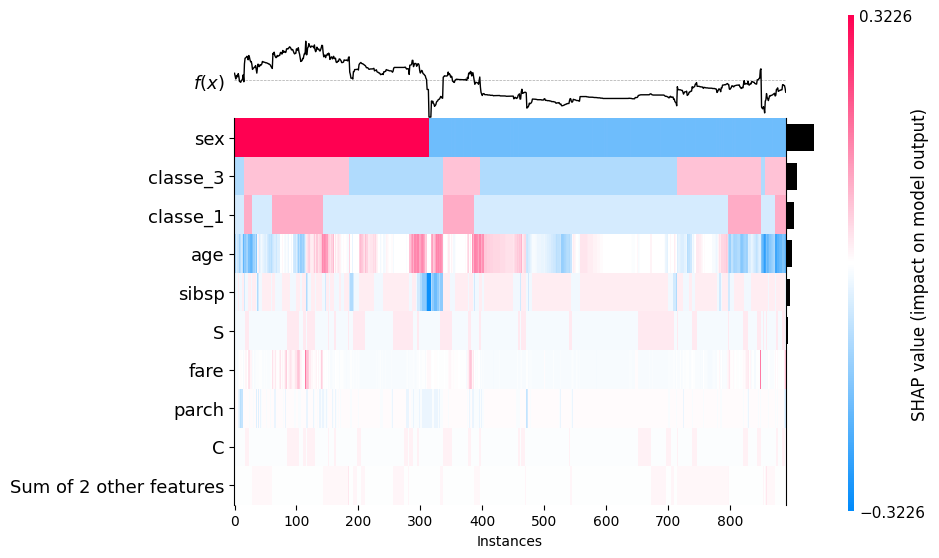

<Axes: xlabel='Instances'>

In [35]:
shap.plots.heatmap(shap_values)


### Explicando um XGBoost

Vamos agora tentar explicar usando um modelo como o XGBoost.



In [36]:
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)


Vamos agora computar os shap-values.

In [37]:
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X100)

Finalmente, vamos computar o gráfico

(<Figure size 640x480 with 4 Axes>,
 <Axes: xlabel='sex', ylabel='E[f(x) | sex]'>)

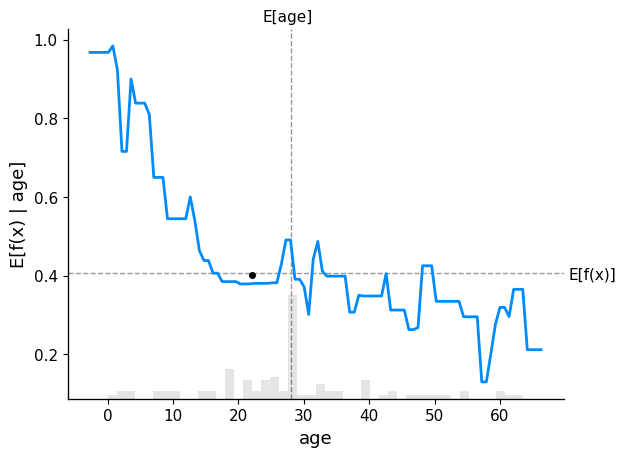

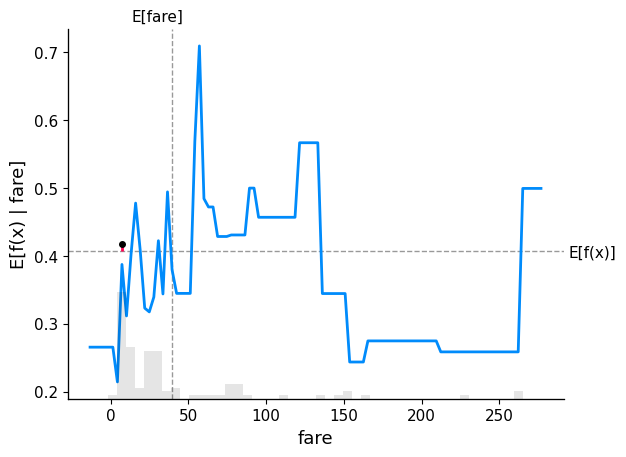

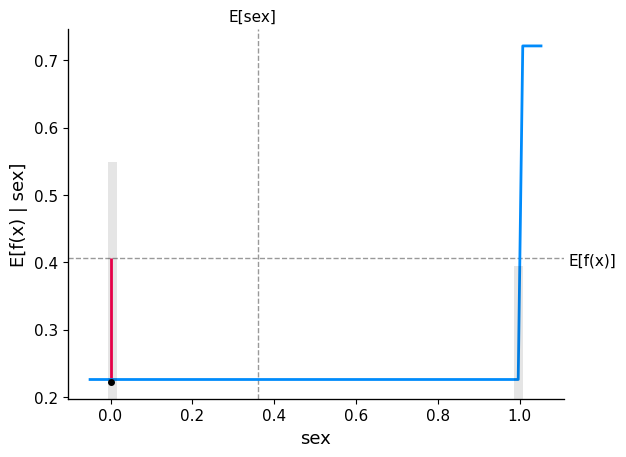

In [39]:
sample_ind = 60
shap.partial_dependence_plot(
    "age", model_xgb.predict, X100, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_xgb[sample_ind:sample_ind+1,:]
)

shap.partial_dependence_plot(
    "fare", model_xgb.predict, X100, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_xgb[sample_ind:sample_ind+1,:]
)

shap.partial_dependence_plot(
    "sex", model_xgb.predict, X100, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_xgb[sample_ind:sample_ind+1,:]
)

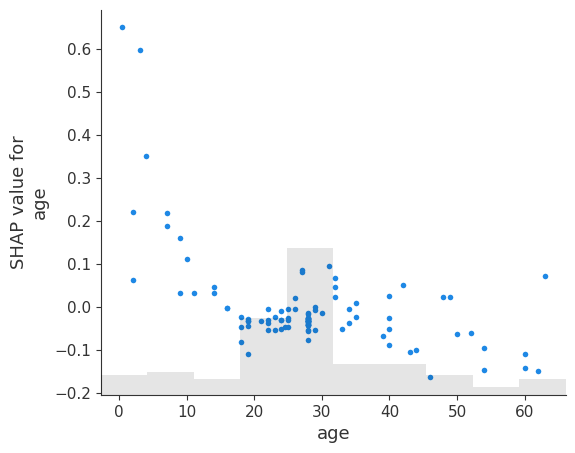

In [40]:
shap.plots.scatter(shap_values_xgb[:,"age"])


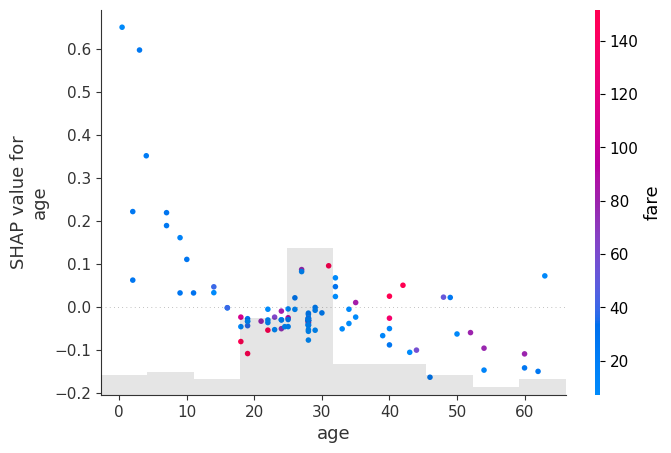

In [41]:
shap.plots.scatter(shap_values_xgb[:,"age"], color = shap_values_xgb)


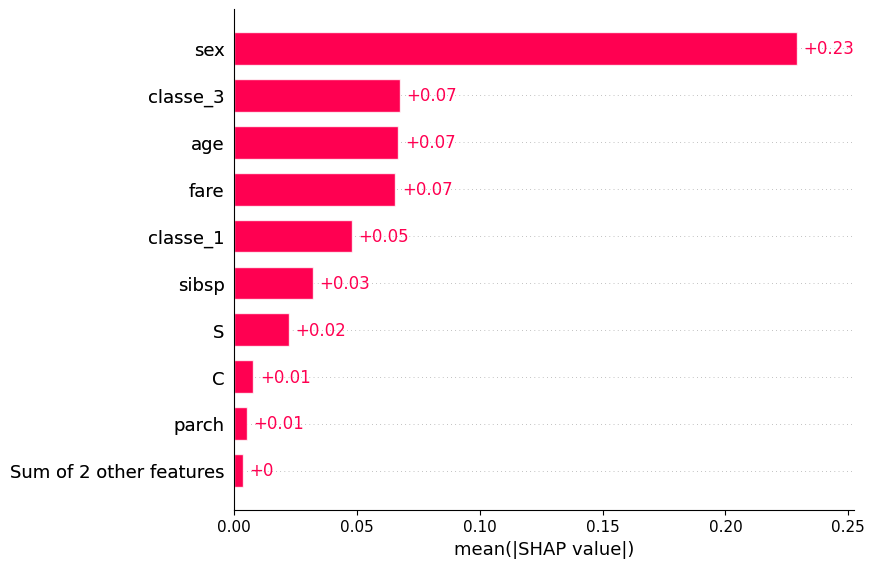

In [42]:
shap.plots.bar(shap_values_xgb)


### Explicando um LogisticRegressor

In [43]:
model_log = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_log.fit(X, y)

LogisticRegression(max_iter=10000)

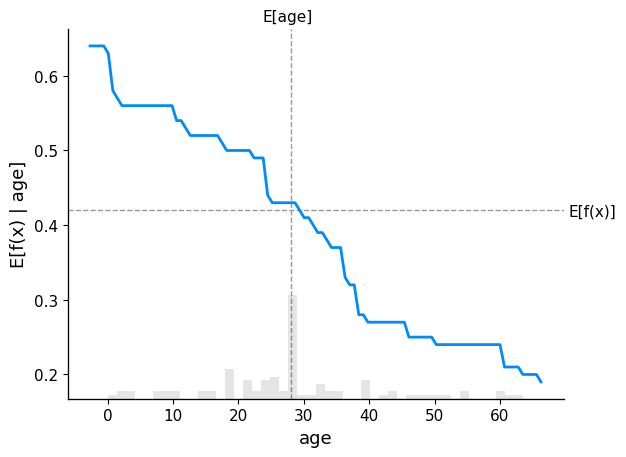

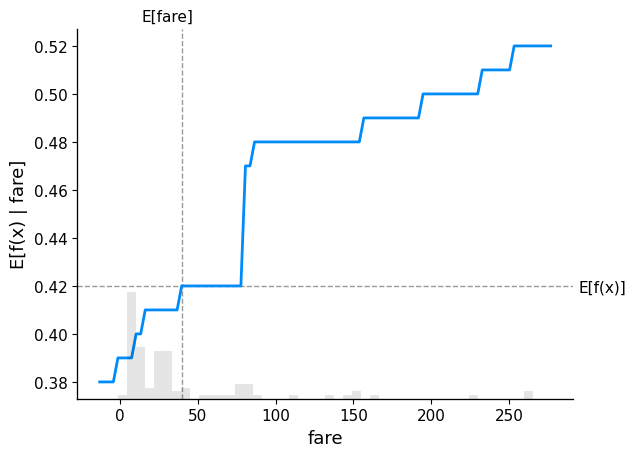

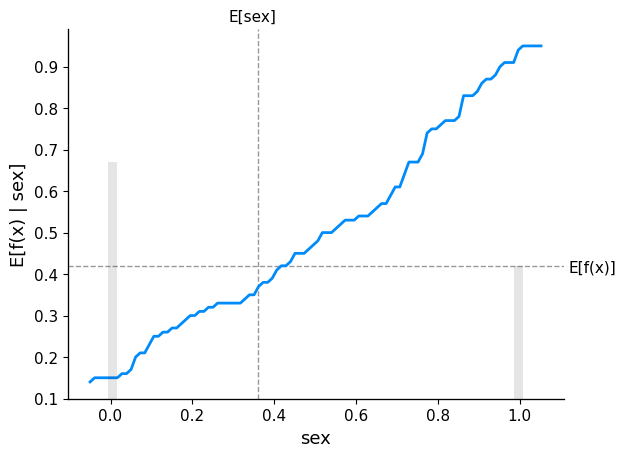

In [44]:
shap.partial_dependence_plot(
    "age", model_log.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)
shap.partial_dependence_plot(
    "fare", model_log.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)
shap.partial_dependence_plot(
    "sex", model_log.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Observe que, ao invés de plotarmos as predições,  plotar as probabilidades.

In [45]:
def model_adult_proba(x):
    return model_log.predict_proba(x)[:,1]

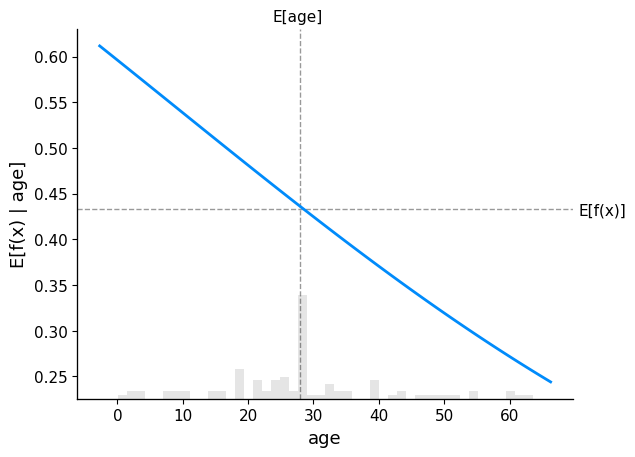

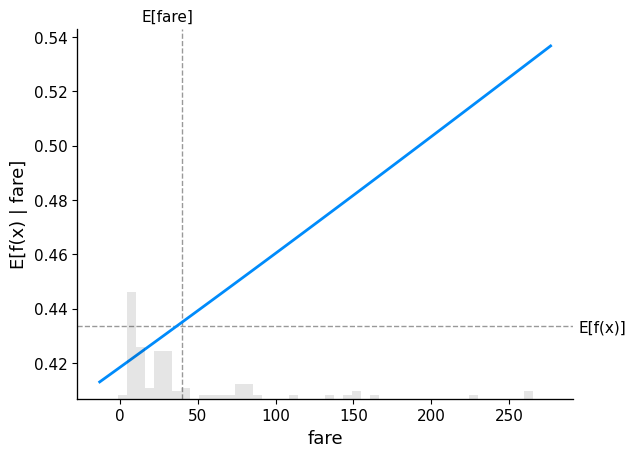

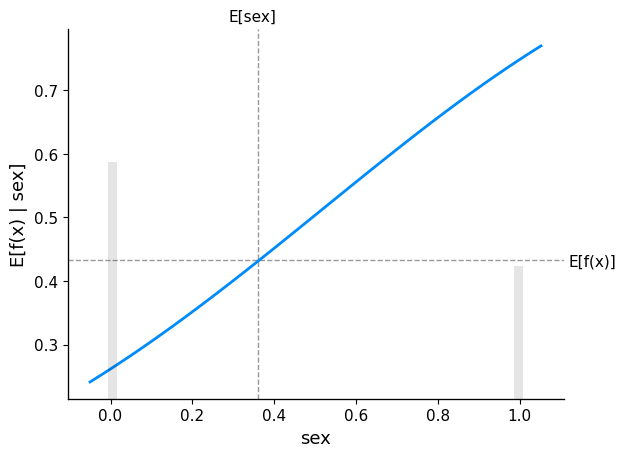

In [46]:
shap.partial_dependence_plot(
    "age", model_adult_proba, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)
shap.partial_dependence_plot(
    "fare", model_adult_proba, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)
shap.partial_dependence_plot(
    "sex", model_adult_proba, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Se usarmos SHAP para explicar a probabilidade de um modelo de regressão logística, vemos fortes efeitos de interação. Isto ocorre porque um modelo de regressão logística NÃO é aditivo no espaço de probabilidade.



In [47]:
explainer = shap.Explainer(model_adult_proba, X100)
shap_values_log = explainer(X100)

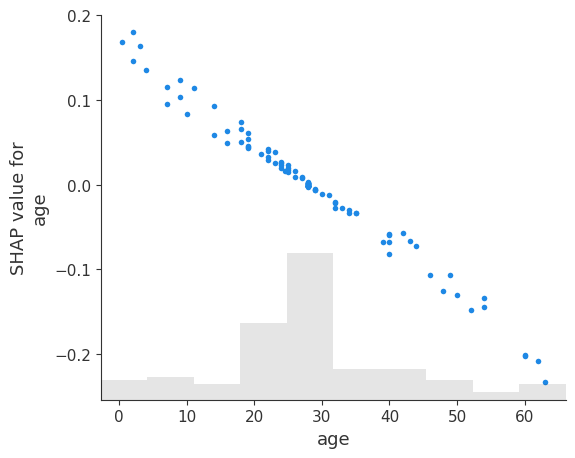

In [48]:
shap.plots.scatter(shap_values_log[:,"age"])


Se em vez disso explicarmos a saída de log-odds do modelo, vemos uma relação linear perfeita entre as entradas e as saídas do modelo. É importante lembrar quais são as unidades do modelo que você está explicando, e que explicar as diferentes saídas do modelo pode levar a visões muito diferentes do comportamento do modelo.

In [49]:
def model_adult_log_odds(x):
    p = model_log.predict_log_proba(x)
    return p[:,1] - p[:,0]

explainer_log_odds = shap.Explainer(model_adult_log_odds, X100)
shap_values_log_odds = explainer_log_odds(X100)

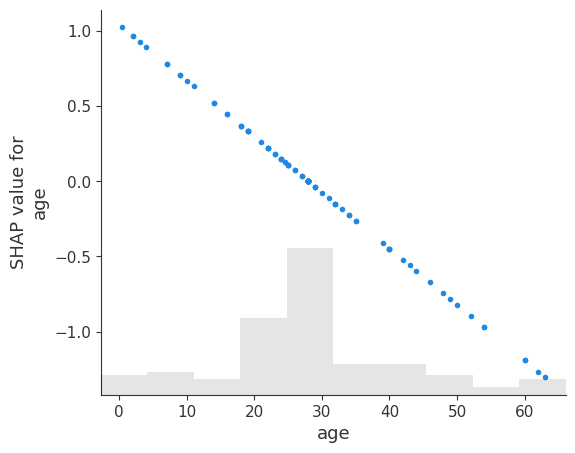

In [50]:
shap.plots.scatter(shap_values_log_odds[:,"age"])


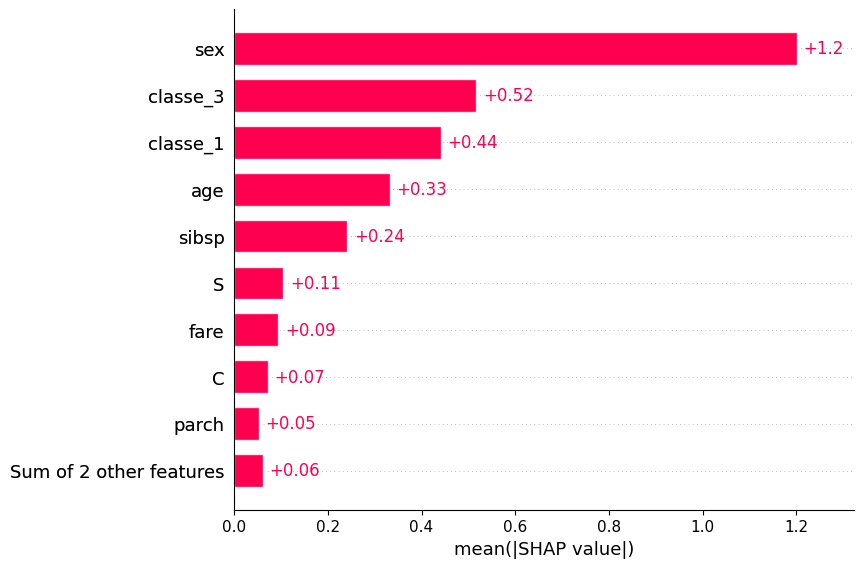

In [51]:
shap.plots.bar(shap_values_log_odds)


## Explicabilidade em Imagens

As tarefas de classificação de imagens podem ser explicadas pela pontuação de cada pixel em uma imagem prevista, o que indica o quanto ele contribui para classificar essa imagem em uma determinada classe. Essa abordagem também é útil para apresentar os resultados de uma forma igualmente gráfica, com imagens. Vejamos um exemplo com o banco de dados MNIST.

### Criando o Modelo

In [52]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

In [54]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True,
)


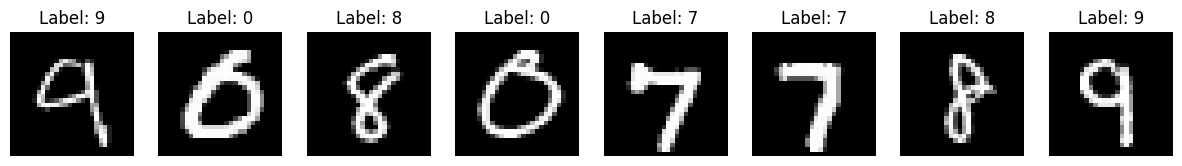

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Obter um lote de imagens do train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Escolher o número de imagens a serem exibidas
num_images = 8  # Número de imagens para exibir
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

# Iterar pelas imagens e mostrar
for i in range(num_images):
    image = images[i].squeeze().numpy()  # Remover a dimensão extra e converter para numpy
    label = labels[i].item()
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")  # Ocultar os eixos

plt.show()


In [56]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [57]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )

In [58]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

num_epochs = 2
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318040
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.160439
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.242491
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.880244
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.706071

Test set: Average loss: 0.0050, Accuracy: 8791/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.671707
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.769718
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.593778
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.509141
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.432510

Test set: Average loss: 0.0028, Accuracy: 9298/10000 (93%)



In [60]:
# como shuffle=True, estamos pegando um exemplo ao acaso do banco de dados de teste
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [61]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

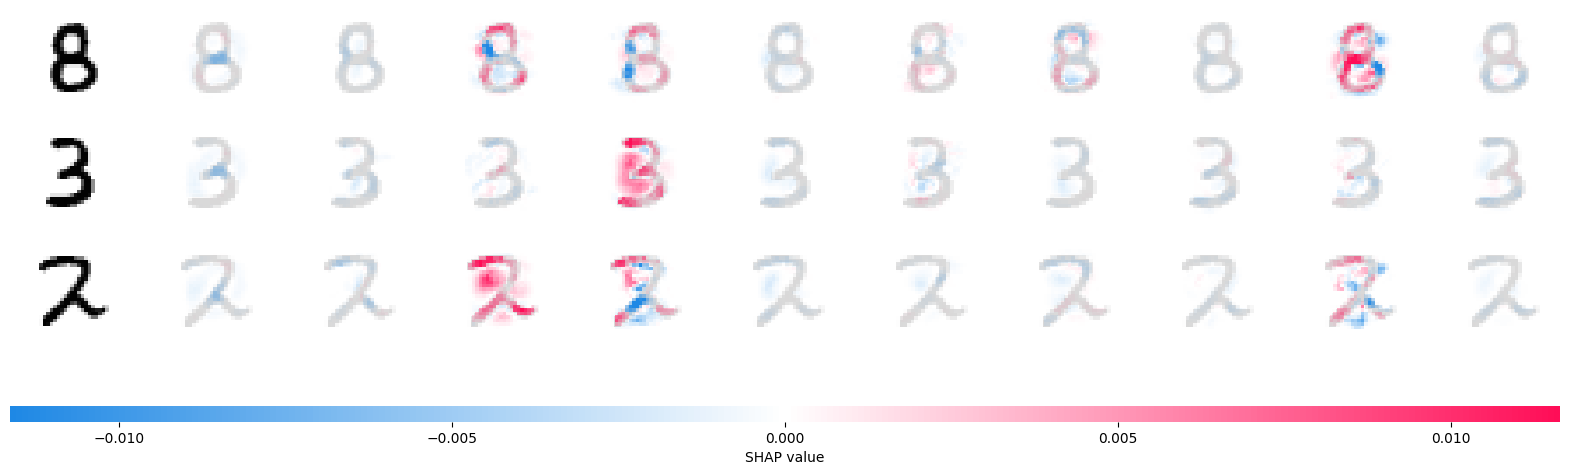

In [62]:
# Plotando os valores de Shapley para cada Feature
shap.image_plot(shap_numpy, -test_numpy)
